<a href="https://colab.research.google.com/github/ANS1514/Projects_in_AI-ML/blob/main/hw4_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
# Load dataset
df = pd.read_csv('/content/all_stocks_2006-01-01_to_2018-01-01.csv')

print(df)

             Date   Open   High    Low  Close    Volume  Name
0      2006-01-03  77.76  79.35  77.24  79.11   3117200   MMM
1      2006-01-04  79.49  79.49  78.25  78.71   2558000   MMM
2      2006-01-05  78.41  78.65  77.56  77.99   2529500   MMM
3      2006-01-06  78.64  78.90  77.64  78.63   2479500   MMM
4      2006-01-09  78.50  79.83  78.46  79.02   1845600   MMM
...           ...    ...    ...    ...    ...       ...   ...
93607  2017-12-22  71.42  71.87  71.22  71.58  10979165  AABA
93608  2017-12-26  70.94  71.39  69.63  69.86   8542802  AABA
93609  2017-12-27  69.77  70.49  69.69  70.06   6345124  AABA
93610  2017-12-28  70.12  70.32  69.51  69.82   7556877  AABA
93611  2017-12-29  69.79  70.13  69.43  69.85   6613070  AABA

[93612 rows x 7 columns]


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

# Check the column that holds the stock name
stock_symbol = 'AAPL'
df_stock = df[df['Name'] == stock_symbol].sort_values('Date')

df_stock = df_stock.reset_index(drop=True)
print("Stock data for", stock_symbol, ":", df_stock.head())

# Normalize the closing prices using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_stock['close_norm'] = scaler.fit_transform(df_stock[['Close']])

Stock data for AAPL :         Date   Open   High    Low  Close     Volume  Name
0 2006-01-03  10.34  10.68  10.32  10.68  201853036  AAPL
1 2006-01-04  10.73  10.85  10.64  10.71  155225609  AAPL
2 2006-01-05  10.69  10.70  10.54  10.63  112396081  AAPL
3 2006-01-06  10.75  10.96  10.65  10.90  176139334  AAPL
4 2006-01-09  10.96  11.03  10.82  10.86  168861224  AAPL


In [4]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 20
data_values = df_stock['close_norm'].values
X, y = create_sequences(data_values, seq_length)
print("Input shape:", X.shape, "Target shape:", y.shape)

# Split the data into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(1), self.y[idx]

batch_size = 64
train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)
test_dataset = StockDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class BasicRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(BasicRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze()

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze()

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze()

# 4. Feed-Forward Network
class FFNModel(nn.Module):
    def __init__(self, seq_length, hidden_size=50):
        super(FFNModel, self).__init__()
        self.fc1 = nn.Linear(seq_length, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001, device='cpu'):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}")

    return train_losses, val_losses

def evaluate_model(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()
    criterion = nn.MSELoss()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    test_loss = running_loss / len(test_loader.dataset)
    rmse = np.sqrt(test_loss)
    print(f"Test MSE: {test_loss:.6f} | Test RMSE: {rmse:.6f}")
    return test_loss, rmse

Input shape: (2999, 20) Target shape: (2999,)
Train: (2099, 20) (2099,)
Validation: (449, 20) (449,)
Test: (451, 20) (451,)


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 50
lr = 0.001

print("\n--- Training Basic RNN Model ---")
basic_rnn = BasicRNNModel(input_size=1, hidden_size=50, num_layers=1)
train_losses_rnn, val_losses_rnn = train_model(basic_rnn, train_loader, val_loader, num_epochs, lr, device)
evaluate_model(basic_rnn, test_loader, device)

print("\n--- Training LSTM Model ---")
lstm_model = LSTMModel(input_size=1, hidden_size=50, num_layers=1)
train_losses_lstm, val_losses_lstm = train_model(lstm_model, train_loader, val_loader, num_epochs, lr, device)
evaluate_model(lstm_model, test_loader, device)

print("\n--- Training GRU Model ---")
gru_model = GRUModel(input_size=1, hidden_size=50, num_layers=1)
train_losses_gru, val_losses_gru = train_model(gru_model, train_loader, val_loader, num_epochs, lr, device)
evaluate_model(gru_model, test_loader, device)

print("\n--- Training Feed-Forward Network Baseline ---")
ffn_model = FFNModel(seq_length=seq_length, hidden_size=50)
train_losses_ffn, val_losses_ffn = train_model(ffn_model, train_loader, val_loader, num_epochs, lr, device)
evaluate_model(ffn_model, test_loader, device)


--- Training Basic RNN Model ---


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50 - Train Loss: 0.035685 | Val Loss: 0.138321
Epoch 2/50 - Train Loss: 0.007775 | Val Loss: 0.002371
Epoch 3/50 - Train Loss: 0.000293 | Val Loss: 0.002826
Epoch 4/50 - Train Loss: 0.000091 | Val Loss: 0.001169
Epoch 5/50 - Train Loss: 0.000085 | Val Loss: 0.001446
Epoch 6/50 - Train Loss: 0.000082 | Val Loss: 0.001359
Epoch 7/50 - Train Loss: 0.000078 | Val Loss: 0.001470
Epoch 8/50 - Train Loss: 0.000078 | Val Loss: 0.001215
Epoch 9/50 - Train Loss: 0.000078 | Val Loss: 0.001366
Epoch 10/50 - Train Loss: 0.000078 | Val Loss: 0.001080
Epoch 11/50 - Train Loss: 0.000079 | Val Loss: 0.000927
Epoch 12/50 - Train Loss: 0.000073 | Val Loss: 0.001012
Epoch 13/50 - Train Loss: 0.000075 | Val Loss: 0.000812
Epoch 14/50 - Train Loss: 0.000075 | Val Loss: 0.000690
Epoch 15/50 - Train Loss: 0.000072 | Val Loss: 0.000763
Epoch 16/50 - Train Loss: 0.000071 | Val Loss: 0.000546
Epoch 17/50 - Train Loss: 0.000075 | Val Loss: 0.000536
Epoch 18/50 - Train Loss: 0.000071 | Val Loss: 0.000845
E

(0.001969280866431093, np.float64(0.04437658015700503))

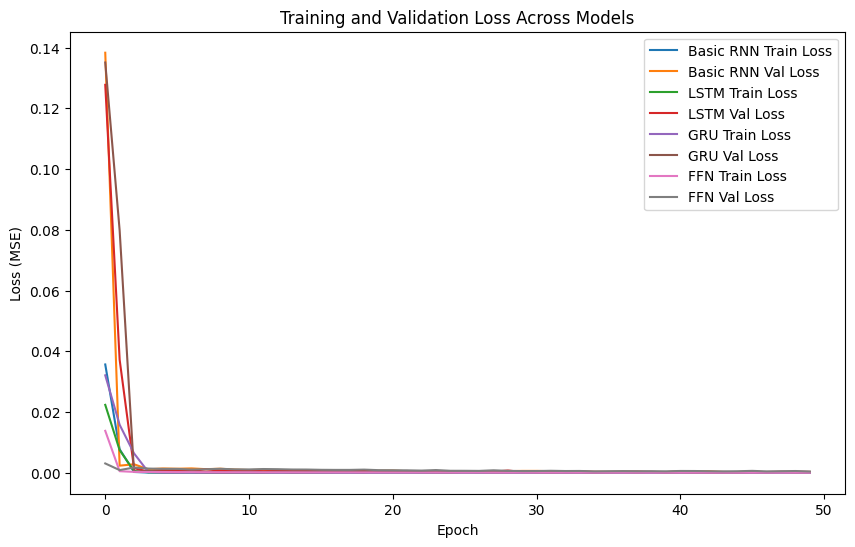

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_rnn, label='Basic RNN Train Loss')
plt.plot(val_losses_rnn, label='Basic RNN Val Loss')
plt.plot(train_losses_lstm, label='LSTM Train Loss')
plt.plot(val_losses_lstm, label='LSTM Val Loss')
plt.plot(train_losses_gru, label='GRU Train Loss')
plt.plot(val_losses_gru, label='GRU Val Loss')
plt.plot(train_losses_ffn, label='FFN Train Loss')
plt.plot(val_losses_ffn, label='FFN Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Across Models")
plt.legend()
plt.show()